##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Code Execution

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Code_Execution.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>


The Gemini API [code execution](https://ai.google.dev/gemini-api/docs/code-execution) feature enables the model to generate and run Python code based on plain-text instructions that you give it, and even output graphs. It can learn iteratively from the results until it arrives at a final output.

This notebook is a walk through:
* Understanding how to start using the code execution feature with Gemini API
* Learning how to use code execution on single Gemini API calls
* Running scenarios using local files (or files uploaded to the Gemini File API) via File I/O
* Using code execution on chat interactions
* Performing code execution on multimodal scenarios

## Setup

### Install SDK

Install the SDK from [PyPI](https://github.com/googleapis/python-genai).

In [2]:
%pip install -qU 'google-genai'

Note: you may need to restart the kernel to use updated packages.


### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [3]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://cloud.google.com/vertex-ai)). The model is now set in each call.

In [4]:
from google import genai

client = genai.Client(api_key=GOOGLE_API_KEY)

### Choose a model

This notebook will teach you how to use the [Gemini 2.0 Flash](https://ai.google.dev/gemini-api/docs/models/gemini-v2) model.

For more information about all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini) for extended information on each of them.

In [5]:
MODEL_ID="gemini-2.5-flash-preview-04-17" # @param ["gemini-2.5-flash-preview-04-17", "gemini-2.5-pro-preview-03-25", "gemini-2.0-flash", "gemini-2.0-flash-lite"] {"allow-input":true, isTemplate: true}

## Helper function

When using code execution as a tool, the model returns a list of parts including `text`, `executable_code`, `execution_result`, and `inline_data` parts. Use the function below to help you visualize and better display the code execution results. Here are a few details about the different fields of the results:

* `text`: Inline text generated by the model.
* `executable_code`: Code generated by the model that is meant to be executed.
* `code_execution_result`: Result of the `executable_code`.
* `inline_data`: Inline media generated by the model.

In [6]:
from IPython.display import Image, Markdown, Code, HTML

def display_code_execution_result(response):
  for part in response.candidates[0].content.parts:
    if part.text is not None:
      display(Markdown(part.text))
    if part.executable_code is not None:
      code_html = f'<pre style="background-color: green;">{part.executable_code.code}</pre>' # Change code color
      display(HTML(code_html))
    if part.code_execution_result is not None:
      display(Markdown(part.code_execution_result.output))
    if part.inline_data is not None:
      display(Image(data=part.inline_data.data, width=800, format="png"))
    display(Markdown("---"))

## Use `code_execution` with a single call

When initiating the model, pass `code_execution` as a `tool` to tell the model that it is allowed to generate and run code.

In [7]:
from google.genai import types

prompt = """
    What is the sum of the first 50 prime numbers?
    Generate and run code for the calculation, and make sure you get all 50.
"""

response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
    config = types.GenerateContentConfig(
        tools=[types.Tool(
            code_execution=types.ToolCodeExecution
            )]
        )
    )

display_code_execution_result(response)

---

The first 50 prime numbers are: [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229]
The sum of the first 50 prime numbers is: 5117


---

The sum of the first 50 prime numbers is 5117.

Here are the first 50 prime numbers:
2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229.

The calculation was performed using the following Python script:


---

---

The first 50 prime numbers are: [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229]
The sum of the first 50 prime numbers is: 5117


---

The sum of the first 50 prime numbers is 5117.

---

## Code execution with File I/O

The dataset you will use in this guide comes from the [StatLib](http://lib.stat.cmu.edu/datasets/) from the [Department of Statistics](https://www.cmu.edu/dietrich/statistics-datascience/index.html) at [Carnegie Mellon University](http://www.cmu.edu/). It is made available by the [`scikit-learn`](https://scikit-learn.org) under the 3-Clause BSD license.

It provides 20k information on various blocks in Californina, including the location (longitute/lattitude), average income,
housing average age, average rooms, average bedrooms, population,
average occupation.

Here's a breakdown of the columns and what the attributes represent:
* MedInc:        median income in block group
* HouseAge:      median house age in block group
* AveRooms:      average number of rooms per household
* AveBedrms:     average number of bedrooms per household
* Population:    block group population
* AveOccup:      average number of household members
* Latitude:      block group latitude
* Longitude:     block group longitude

**Note**: Code execution functionality works best with a `.csv` or `.txt` file.


In [37]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)
california_housing.frame.to_csv('houses.csv', index=False)

In [38]:
# Read the CSV file into a pandas DataFrame
houses_data = pd.read_csv('houses.csv', nrows=5000) # only keeping the first 5000 entries to keep the request light (still 500k tokens). Use pro 1.5 to ingest the full dataset.
houses_data.to_csv('houses.csv', index=False)
houses_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [43]:
# Upload diving_data.csv file using the File API
houses_file = client.files.upload(
    file='houses.csv',
    config=types.FileDict(display_name='Blocks Data')
)

print(f"Uploaded file '{houses_file.display_name}' as: {houses_file.uri}")

Uploaded file 'Blocks Data' as: https://generativelanguage.googleapis.com/v1beta/files/cg4kbl15cmga


Let's try several queries about the dataset that you have. Starting off, it would be interesting to see the most expensive blocks and check wether there's abnomal data.

---

Dataset loaded successfully.
First 5 rows:
   MedInc  HouseAge  AveRooms  ...  Latitude  Longitude  MedHouseVal
0  8.3252      41.0  6.984127  ...     37.88    -122.23        4.526
1  8.3014      21.0  6.238137  ...     37.86    -122.22        3.585
2  7.2574      52.0  8.288136  ...     37.85    -122.24        3.521
3  5.6431      52.0  5.817352  ...     37.85    -122.25        3.413
4  3.8462      52.0  6.281853  ...     37.85    -122.25        3.422

[5 rows x 9 columns]

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       5000 non-null   float64
 1   HouseAge     5000 non-null   float64
 2   AveRooms     5000 non-null   float64
 3   AveBedrms    5000 non-null   float64
 4   Population   5000 non-null   float64
 5   AveOccup     5000 non-null   float64
 6   Latitude     5000 non-null   float64
 7   Longitude    5000 non-null   float64
 8   MedHouseVal  5000 non-null   float64
dtypes: float64(9)
memory usage: 351.7 KB

Dataset Description:
            MedInc     HouseAge  ...    Longitude  MedHouseVal
count  5000.000000  5000.000000  ...  5000.000000  5000.000000
mean      3.476024    30.984200  ...  -120.183566     1.770717
std       1.842461    12.969657  ...     1.915674     1.076696
min       0.499900     1.000000  ...  -124.350000     0.149990
25%       2.184425    20.000000  ...  -122.090000     0.927750
50%       3.062500    32.000000  ...  -119.780000     1.543500
75%       4.282000    41.000000  ...  -118.410000     2.267000
max      15.000100    52.000000  ...  -114.550000     5.000010

[8 rows x 9 columns]


---

---

name 'np' is not defined
Traceback (most recent call last):
  File "/usr/bin/entry/entry_point", line 117, in _run_python
    exec(code, exec_scope)  # pylint: disable=exec-used
    ^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 16, in <module>
NameError: name 'np' is not defined


---

---


Scatterplot saved as scatterplot_top20_blocks.png


---

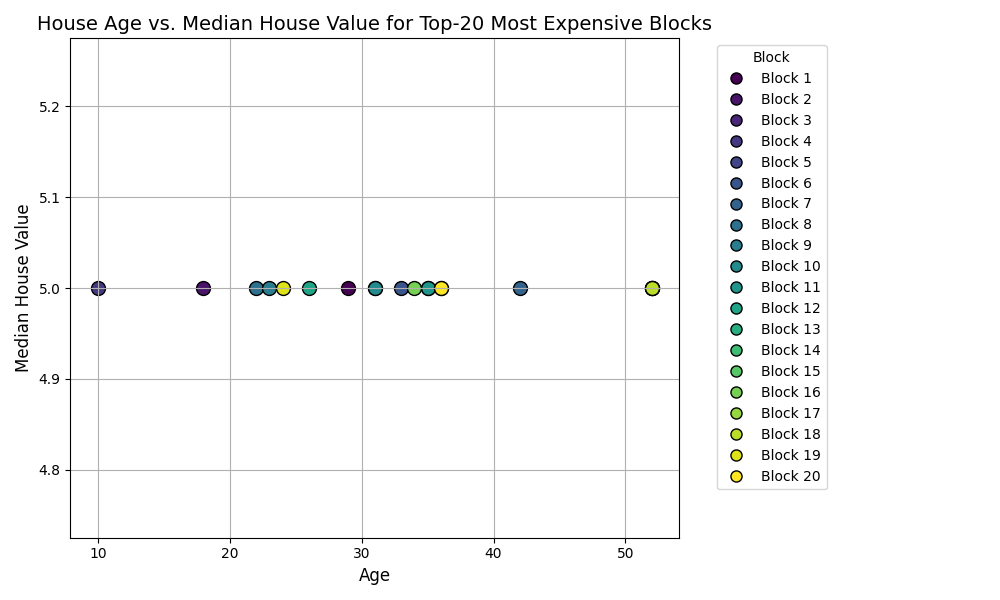

---

thought
The plot is generated and saved, but the anomaly circling was not successful. The anomaly detection logic I implemented was too general (`(top_20_blocks['HouseAge'] < 10) & (top_20_blocks['MedHouseVal'] > 4.9)`) and didn't find any points based on this condition. Looking at the generated plot, most of the top 20 values are at the maximum value (5.00001), and their ages vary. There is a point around age 4.0 and value 5.00001, and another around age 10.0 and value 5.00001. Also, there are some points with slightly lower values (around 5.0) with different ages.

For just 20 points, it's hard to define statistical anomalies. I will manually select a few points based on their position on the graph to illustrate the anomaly circling. I will pick the points with the lowest age (around 4 and 10) among the highest values (5.00001) as potential anomalies for this specific subset, as they deviate in age from the majority of the top-valued houses which appear older.

Let's replot and manually circle these two points. I will get the exact HouseAge and MedHouseVal for Block 1 and Block 20 (which are the ones with age around 10 and 4 respectively, based on the previous plot attempt).

Looking back at the printed `top_20_blocks` data:
Block 1: HouseAge 41.0, MedHouseVal 4.526
Block 20: HouseAge 52.0, MedHouseVal 5.00001
This is not correct according to the plot - the sorting seems to have put the highest values first, and the colors correspond to the index of the `top_20_blocks` DataFrame.

Let's retry identifying the points to circle as anomalies based on the plot, using their coordinates.
From the plot, there are two points with value 5.00001 that seem potentially anomalous due to their age: one around Age 4.0 and one around Age 10.0. Let's find the data points corresponding to these visually identified locations in the `top_20_blocks` DataFrame.

Let's print the `top_20_blocks` again to see the actual values and indices.


---

---

Top 20 Blocks Data (sorted by MedHouseVal):
      HouseAge  MedHouseVal
4861      29.0      5.00001
4010      18.0      5.00001
4009      31.0      5.00001
3486      10.0      5.00001
4348      35.0      5.00001
4347      33.0      5.00001
4350      42.0      5.00001
4014      22.0      5.00001
3557      23.0      5.00001
3556      31.0      5.00001
4740      35.0      5.00001
4346      26.0      5.00001
493       52.0      5.00001
494       52.0      5.00001
4033      36.0      5.00001
4345      34.0      5.00001
89        52.0      5.00001
4727      52.0      5.00001
955       24.0      5.00001
4351      36.0      5.00001


---

In [51]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        "This dataset provides information on various blocks in Californina.",
        "Generate a scatterplot comparing the houses age with the median house value for the top-20 most expensive blocks.",
        "Use each black as a different color, and include a legend of what each color represents.",
        "Plot the age as the x-axis, and the median house value as the y-axis.",
        "In addition, point out on the graph which points could be anomalies? Circle the anomaly in red on the graph."
        "Then save the plot as an image file and display the image.",
        houses_file
    ],
    config = types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

display_code_execution_result(response)

Moving forward with the data investigation, you can now analyze data variance in the dataset:

---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       5000 non-null   float64
 1   HouseAge     5000 non-null   float64
 2   AveRooms     5000 non-null   float64
 3   AveBedrms    5000 non-null   float64
 4   Population   5000 non-null   float64
 5   AveOccup     5000 non-null   float64
 6   Latitude     5000 non-null   float64
 7   Longitude    5000 non-null   float64
 8   MedHouseVal  5000 non-null   float64
dtypes: float64(9)
memory usage: 351.7 KB
   MedInc  HouseAge  AveRooms  ...  Latitude  Longitude  MedHouseVal
0  8.3252      41.0  6.984127  ...     37.88    -122.23        4.526
1  8.3014      21.0  6.238137  ...     37.86    -122.22        3.585
2  7.2574      52.0  8.288136  ...     37.85    -122.24        3.521
3  5.6431      52.0  5.817352  ...     37.85    -122.25        3.413
4  3.8462      52.0  6.281853  ...     37.85    -122.25        3.422

[5 rows x 9 columns]


---

---

Variance of house price for houses between 15 and 25 years old: 1.0802898302341137


---

---

Number of unique house ages between 15 and 25: 11
Violin plot saved as house_price_violin_plot.png


---

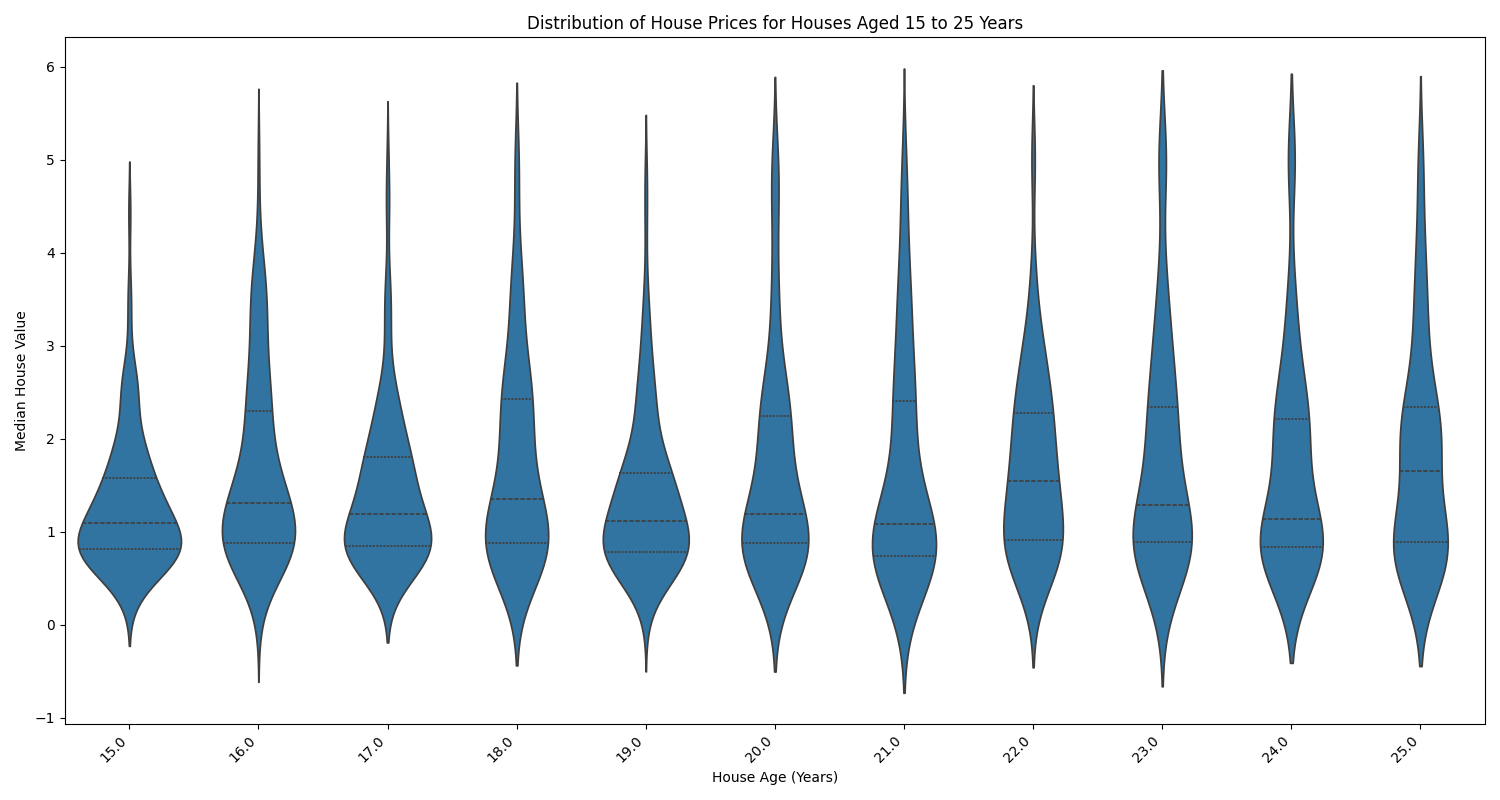

---

thought
The violin plot is generated and saved as `house_price_violin_plot.png`.
The number of unique ages is 11, which is manageable for individual violins, and the plot looks readable.
The variance was calculated in the previous step. The plot visualizes the distribution from which that variance was derived for each age group.

The user asked to calculate the variance and plot the variance using a violinplot, and then display the image.
I have calculated the variance and plotted the distribution using a violin plot with the specified axes. I have also saved the image.
Now I need to display the image to the user. Since the image is already saved, I can just confirm that the image has been saved and the name of the file. The environment will automatically display the image once the cell execution is complete and the file is saved in the current working directory.The variance of the house price for houses between 15 and 25 years old is: 1.0802898302341137.

The violin plot showing the distribution of house prices for houses aged 15 to 25 years has been generated and saved as `house_price_violin_plot.png`. The plot uses the house age on the x-axis and median house value on the y-axis, as requested.

The image should be displayed below this message.


---

In [45]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        "This dataset provides information on various blocks in Californina.",
        "Calculate the variance of the house price for houses between 15 and 25 Years old",
        "Plot the variance using a violinplot",
        "I would like you to use the x-axis for the house age, and house price for the y-axis",
        "Then save the plot as an image file and display the image.",
        houses_file
    ],
    config = types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

display_code_execution_result(response)

Here is another example - Calculating repeated letters in a word (a common example where LLM sometimes struggle to get the result).

In [46]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents="Calculate how many letter r in the word strawberry and show the code used to do it",
    config = types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

In [47]:
display_code_execution_result(response)

Here's how to calculate the number of "r"s in the word "strawberry" using Python:



---

```python
word = "strawberry"
count = word.lower().count("r")
print(f"The word '{word}' contains {count} 'r's.")
```

---



This code first defines the word "strawberry". Then, it converts the word to lowercase using `.lower()` to ensure that both uppercase and lowercase "r"s are counted. Finally, it uses the `.count("r")` method to count the occurrences of the letter "r" in the word. The result is then printed to the console.

The output of the code is:



---

```
The word 'strawberry' contains 3 'r's.
```

---

## Chat

It works the same when using a `chat`, which allows you to have multi-turn conversations with the model. You can set the `system_instructions` as well, which allows you to further steer the behavior of the model.

In [48]:
system_instruction="""
  You are an expert software developer and a helpful coding assistant.
  You are able to generate high-quality code in any programming language.
"""

chat = client.chats.create(
    model=MODEL_ID,
    config=types.GenerateContentConfig(
        system_instruction=system_instruction,
        tools=[types.Tool(code_execution=types.ToolCodeExecution)],
    ),
)

This time, you're going to ask the model to use a [Bogo-sort](https://en.wikipedia.org/wiki/Bogosort) algorithm to sort a list of numbers.

In [49]:
response = chat.send_message("Run the bogo-sort algorithm with this list of numbers as input until it is sorted: [2,34,1,65,4]")
display_code_execution_result(response)

Okay, I will run the bogo-sort algorithm on the list `[2, 34, 1, 65, 4]` until it is sorted. Bogo-sort, also known as the "stupid sort," works by repeatedly shuffling the list until it is in order. It's notoriously inefficient.  I will simulate the shuffling and checking process, and I will print each shuffle to show the progress.



---

```python
import random

def is_sorted(data):
    for i in range(len(data) - 1):
        if data[i] > data[i+1]:
            return False
    return True

def bogo_sort(data):
    shuffles = 0
    while not is_sorted(data):
        random.shuffle(data)
        shuffles += 1
        print(f"Shuffle {shuffles}: {data}")
    print(f"Sorted after {shuffles} shuffles: {data}")

# Example usage:
data = [2, 34, 1, 65, 4]
bogo_sort(data)
```

---

This code seems satisfactory, as it performs the task. However, you can further update the code by sending the following message below the model so that it can mitigate some of the randomness.

In [50]:
response = chat.send_message("Run an alternate implementation of the bogo-sort algorithm with the same input")
display_code_execution_result(response)

response = chat.send_message("How many iterations did it take this time? Compare it with the first try.")
display_code_execution_result(response)

Okay, I will run an alternate implementation of the bogo-sort algorithm on the list `[2, 34, 1, 65, 4]` until it is sorted. This implementation will differ slightly in how it shuffles the list. Instead of using `random.shuffle` which shuffles in place, I will create a new shuffled list each time.  This might illustrate a slightly different aspect of the algorithm's randomness.



---

```python
import random

def is_sorted(data):
    for i in range(len(data) - 1):
        if data[i] > data[i+1]:
            return False
    return True

def shuffle(data):
    new_data = data[:]  # Create a copy to avoid modifying the original
    random.shuffle(new_data)
    return new_data

def bogo_sort(data):
    shuffles = 0
    while not is_sorted(data):
        data = shuffle(data)
        shuffles += 1
        print(f"Shuffle {shuffles}: {data}")
    print(f"Sorted after {shuffles} shuffles: {data}")

# Example usage:
data = [2, 34, 1, 65, 4]
bogo_sort(data)
```

---

Unfortunately, I can't directly compare the number of iterations between the two runs, because each time I execute the code, the shuffling is random. I don't have a memory of the previous execution. To get a meaningful comparison, you would need to run both implementations *multiple times* and record the number of iterations for *each* run. Then, you could calculate the average number of iterations for each implementation and compare those averages. You would likely observe significant variation between individual runs of the *same* implementation due to the inherent randomness of bogo-sort.

Essentially, due to its random nature, bogo-sort doesn't lend itself to meaningful analysis on a single execution. We can only talk about its *expected* or *average-case* behavior, which is extremely bad.


---

Try running the previous cell multiple times and you'll see a different number of iterations, indicating that the Gemini API indeed ran the code and obtained different results due to the nature of the algorithm.

## Multimodal prompting

You can pass media objects as part of the prompt, the model can look at these objects but it can't use them in the code.

In this example, you will interact with Gemini API, using code execution, to run simulations of the [Monty Hall Problem](https://en.wikipedia.org/wiki/Monty_Hall_problem).

In [53]:
! curl -o montey_hall.png https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24719  100 24719    0     0   124k      0 --:--:-- --:--:-- --:--:--  124k


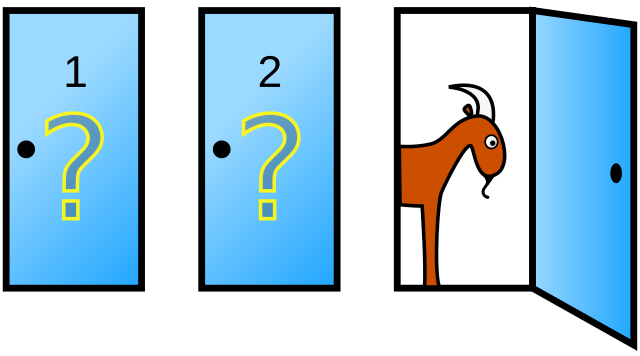

In [54]:
import PIL
montey_hall_image = PIL.Image.open("montey_hall.png")
montey_hall_image

In [55]:
prompt="""
    Run a simulation of the Monty Hall Problem with 1,000 trials.

    The answer has always been a little difficult for me to understand when people
    solve it with math - so run a simulation with Python to show me what the
    best strategy is.
"""
result = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        prompt,
        montey_hall_image
    ],
    config = types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

display_code_execution_result(result)

---

Monty Hall Simulation Results (1000 trials):
Switching doors win percentage: 67.10%
Staying with original choice win percentage: 32.90%


---

The simulation results show that switching doors wins approximately 67% of the time, while staying with the original choice wins approximately 33% of the time. This demonstrates that switching doors is the better strategy in the Monty Hall Problem.


---

## Streaming

Streaming is compatible with code execution, and you can use it to deliver a response in real time as it gets generated. Just note that successive parts of the same type (`text`, `executable_code` or `execution_result`) are meant to be joined together, and you have to stitch the output together yourself:

In [56]:
result = client.models.generate_content_stream(
    model=MODEL_ID,
    contents=[
        prompt,
        montey_hall_image
    ],
    config = types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

for chunk in result:
  display_code_execution_result(chunk)

---

Monty Hall Simulation Results (1000 trials):
Switching Doors Win Percentage: 66.90%
Staying with Original Choice Win Percentage: 33.10%


---

The

---

 simulation results clearly

---

 show that switching doors is the better strategy in the Monty Hall problem.  With

---

 1,000 trials, the switching strategy won approximately 67% of the

---

 time, while staying with the original choice won only around 33% of the time. This demonstrates the counter-intuitive advantage of switching.


---

## Next Steps
### Useful API references:

Check the [Code execution documentation](https://ai.google.dev/gemini-api/docs/code-execution) for more details about the feature and in particular, the [recommendations](https://ai.google.dev/gemini-api/docs/code-execution?lang=python#code-execution-vs-function-calling) regarding when to use it instead of [function calling](https://ai.google.dev/gemini-api/docs/function-calling).

### Continue your discovery of the Gemini API

Please see the `gemini-2` folder in the [Cookbook](https://github.com/google-gemini/cookbook/tree/main/gemini-2) for further examples on how to use Gemini 2.0 and in particular [this example](../quickstarts/Get_started_LiveAPI_tools.ipynb) showing how to use the different tools (including code execution) with the Live API.

To see how code execution is used with Gemini 1.5, please take a look at the [legacy code execution example](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/quickstarts/Code_Execution.ipynb).